<a href="https://colab.research.google.com/github/fmassini/DataScienceCoderhouse/blob/main/Anteriores/Visualizaci%C3%B3n_Massini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

El siguiente dataset contiene información sobre las piezas con su respectivo código (referencia) necesarias para construir distintas versiones de un producto en específico. Estas versiones difieren ya que algunas son más completas que otras, o tienen diferentes funciones, y por ende llevan distintas piezas en su ensamblado.

La mercadería viene en cajones llamados "bases" dentro de contenedores. A su vez, cada caja dentro de estas bases tiene dentro un número determinado de piezas (indicado en el dataset). En resumen, las piezas vienen en cajas, las cuales vienen en bases, las cuales a su vez vienen en contenedores. Toda esta información está detallada en el dataset, donde se indica incluso dimensiones, pesos y tipo de packaging de las bases o cajas.

Lo interesante a ver en este estudio es, definir si existe un patrón en los contenedores y bases en los cuales viene la mercadería, y si ese patrón además se extiende a las 5 versiones existentes (cada fila además aclara a que versión del producto pertenece la pieza, hay piezas comunes a todos y otras que no lo son). Es de particular interés encontrar si existe una combinación de contenedores que, si se los trae primero, esto permita contar con todas las piezas para armar el producto lo antes posible, o si hay que ingresar todo para comenzar a ensamblar.

Una vez traidos los contenedores, las piezas deberán separarse en clases. La clase de una pieza determina de qué forma se ensambla, por lo que es necesario clasificar todo antes de comenzar a armar el producto.
Sabiendo el volumen y peso de piezas, también es de interés determinar que clase es más voluminosa y a cuantas posiciones en una estantería equivaldría. Esto difiere mucho versión a versión?

Fuente: https://docs.google.com/spreadsheets/d/1ouprDoTPf1Ua6wY1ZZ1FbcAgWx1ejaNl/edit?usp=drivesdk&ouid=111044325679429769254&rtpof=true&sd=true

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Files

Mounted at /content/gdrive
/content/gdrive/MyDrive/Files


In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
DSNX=pd.read_excel('DS producto.xlsx',sheet_name='Hoja1') #Cargo DS

In [ ]:
DSNX['CAJAS/BASE'] = DSNX.groupby(['BASE', 'VERSION'])['BASE'].transform('count') #Genero la columna CAJAS/BASE

In [ ]:
DSNX['REFS/BASE'] = DSNX.groupby(['BASE', 'VERSION'])['REFERENCIA'].transform('nunique') #Genero la columna REFS(distintas)/BASE

Como se explicaba en la introducción, para comenzar a producir es necesario clasificar las piezas en clases. Para esto se debe inspeccionar la mercadería que ingresa, aunque no es necesario hacerlo para todas las bases.
A continuación se generan filtros para clasificar las bases según si son inspeccionables o no.

In [ ]:
FILTRO1=DSNX['BASE'].str.startswith(('AF','AP')) #Filtro bases AF y AP, que son las que se podrían llegar a inspeccionar
FILTRO2=DSNX['CAJAS/BASE']>1 #Me quedo con las bases que tienen más de una caja (si tienen una caja sola, no hace falta inspeccionar)
FILTRO3=DSNX['TIPO CAJA']!="WOOD FRAME" #Elimino las bases con cajas de madera (no se inspeccionan)
FILTRO4=DSNX['REFS/BASE']>1 #Me quedo con las bases que tienen más de una referencia (bases monoproducto no hace falta inspeccionar)
DSNX['INSPECCIÓN'] = np.where(FILTRO1 & FILTRO2 & FILTRO3 & FILTRO4, 1, 0) #Genero columna que indica si la base es inspeccionable o no

In [ ]:
DSNX['REFS/CAJA'] = DSNX.groupby(['CAJA', 'VERSION'])['REFERENCIA'].transform('nunique') #Genero la columna REFS(distintas)/CAJA

In [ ]:
DSNX['VOLUMEN CAJA'] = ((DSNX['LARGO CAJA']/1000) * (DSNX['ANCHO CAJA']/1000) * (DSNX['ALTURA CAJA']/1000))/DSNX['REFS/CAJA'] #Genero la columna que indique cuanto volumen ocupa la referencia de la fila en cuestión. Si la caja trae múltiples referencias, divido entre esa cantidad

In [ ]:
DSNX['VOL TOTAL'] = DSNX.groupby(['VERSION','CLASE','REFERENCIA'])['VOLUMEN CAJA'].transform('sum') #La idea aquí es calcular cuanto volumen en total ocuparía cada referencia en su respectiva clase, por versión

In [ ]:
DSNX['CANT PALLETS'] = DSNX['VOL TOTAL']/1.68 #Divido el volumen total entre el volumen de un pallet completo, para ver cuantos representa
DSNX['CANT PALLETS'] = DSNX['CANT PALLETS'].apply(lambda x: math.ceil(x)) #Redondeo para arriba

In [ ]:
DSNX['TIPO PALLET'] = np.where(DSNX['CANT PALLETS']>2, 'DEDICADO', 'MIXTO') #Si, por versión, una referencia junta más de 3 pallets en una clase, voy a armar pallets monoproducto de esa referencia, de lo contrario irá en pallets mezclados
DSNX['TIPO PALLET'] = np.where(DSNX['INSPECCIÓN']==0, 'DIRECTO', DSNX['TIPO PALLET']) #Esto anterior aplica solo a lo inspeccionable, lo otro se considera "directo"
DSNX

,CLASE,VERSION,CONTENEDOR,BASE,TIPO BASE,LARGO BASE,ANCHO BASE,ALTURA BASE,PESO BASE,CAJA,...,REFERENCIA,UNID/CAJA,CAJAS/BASE,REFS/BASE,INSPECCIÓN,REFS/CAJA,VOLUMEN CAJA,VOL TOTAL,CANT PALLETS,TIPO PALLET
0,F1,M42,CMAU4908460,AF0001,IRON FRAME,2110,600,1200,205.0,AF0001,...,2804110-BU01,16,1,1,0,1,0.022100,0.132600,1,DIRECTO
1,F1,M42,CMAU4908460,AF0002,IRON FRAME,2110,600,1200,205.0,AF0002,...,2804110-BU01,16,1,1,0,1,0.022100,0.132600,1,DIRECTO
2,F1,M42,CMAU4908460,AF0003,IRON FRAME,2110,600,1200,205.0,AF0003,...,2804110-BU01,16,1,1,0,1,0.022100,0.132600,1,DIRECTO
3,F1,M42,CMAU4908460,AF0004,IRON FRAME,2110,600,1200,205.0,AF0004,...,2804110-BU01,16,1,1,0,1,0.022100,0.132600,1,DIRECTO
4,F1,M42,CMAU4908460,AF0005,IRON FRAME,2110,600,1200,205.0,AF0005,...,2804110-BU01,16,1,1,0,1,0.022100,0.132600,1,DIRECTO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23599,A,A42,MRSU3285393,MP001,IRON FRAME,2250,1700,1050,861.0,MC0074,...,7100004P201E,96,94,54,0,4,0.022770,0.022770,1,DIRECTO
23600,A,A42,MRSU3285393,MP001,IRON FRAME,2250,1700,1050,861.0,MC0074,...,7100005P201E,96,94,54,0,4,0.022770,0.022770,1,DIRECTO
23601,A,A42,MRSU3285393,MP001,IRON FRAME,2250,1700,1050,861.0,MC0074,...,7200004P201E,96,94,54,0,4,0.022770,0.022770,1,DIRECTO
23602,A,A42,MRSU3285393,MP001,IRON FRAME,2250,1700,1050,861.0,MC0074,...,7200005P201E,96,94,54,0,4,0.022770,0.022770,1,DIRECTO


In [ ]:
DSNX_1 = DSNX.groupby(['CLASE', 'VERSION'])['REFERENCIA'].nunique().unstack() #Quiero saber cuantas referencias distintas hay en cada clase, por versión
DSNX_1['PROMEDIO'] =  DSNX_1.mean(axis=1, skipna=True) #Calculo el promedio por versión
DSNX_1

VERSION,A41,A42,M21,M41,M42,PROMEDIO
CLASE,,,,,,
A,66.0,73.0,66.0,66.0,68.0,67.800000
CA1,25.0,33.0,25.0,25.0,32.0,28.000000
CA2,33.0,33.0,37.0,38.0,38.0,35.800000
CA3,39.0,37.0,39.0,39.0,37.0,38.200000
CA4,44.0,45.0,44.0,44.0,43.0,44.000000
CA5,16.0,16.0,16.0,16.0,16.0,16.000000
CA6,29.0,31.0,29.0,29.0,31.0,29.800000
CA7,20.0,22.0,20.0,20.0,22.0,20.800000
CH1,15.0,15.0,14.0,15.0,15.0,14.800000


### Graficamos cuantas referencias distintas pertenecen a cada clase, promediando por versión.
Lo que vemos, es que la clase 'TO' es la que contiene más variedad de referencias.
Esto tiene sentido ya que las piezas pertenecientes a esta clase suelen ser tornillería.

Matplotlib: GRÁFICO 1

Text(0.5, 1.0, 'REFERENCIAS DISTINTAS INVOLUCRADAS POR CLASE (PROMEDIO POR VERSIÓN)')

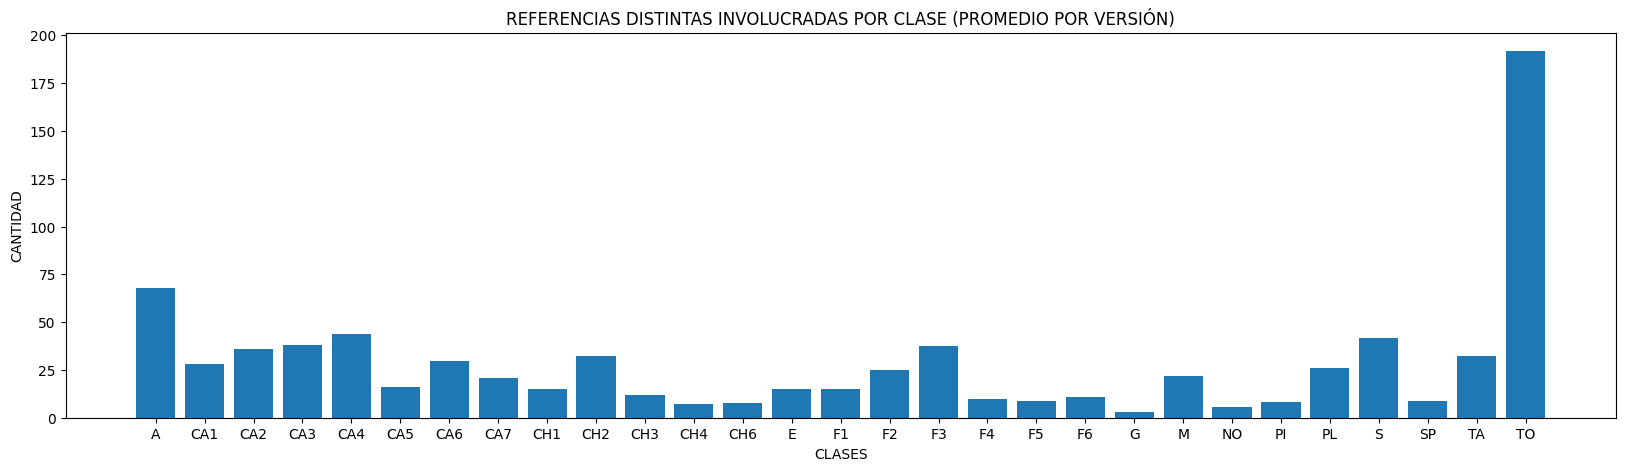

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
ax.bar(DSNX_1.index,DSNX_1['PROMEDIO'])
ax.set_xlabel('CLASES')
ax.set_ylabel('CANTIDAD')
ax.set_title('REFERENCIAS DISTINTAS INVOLUCRADAS POR CLASE (PROMEDIO POR VERSIÓN)')

In [ ]:
DSNX_2 = DSNX.groupby(['REFERENCIA', 'VERSION'])['CAJA'].nunique().unstack() #Quiero saber cuantas cajas vienen por referencia, por versión
DSNX_2 = DSNX_2.fillna(0)
DSNX_2

VERSION,A41,A42,M21,M41,M42
REFERENCIA,,,,,
09103-06002,1.0,1.0,1.0,1.0,1.0
09103-06005,1.0,1.0,1.0,1.0,1.0
09103-06006,1.0,1.0,1.0,1.0,1.0
09103-06006-S111,1.0,1.0,1.0,1.0,1.0
09103-06007,2.0,2.0,1.0,2.0,2.0
...,...,...,...,...,...
N807154,1.0,1.0,1.0,1.0,1.0
Q2734816F31,1.0,1.0,1.0,1.0,1.0
Q4400412,1.0,1.0,1.0,1.0,1.0


### Graficamos cuantas cajas vienen por referencia, diferenciando por versión.
Lo que vemos, es que el total de la mayoría de las referencias vienen en 1 o pocas cajas, solo en casos muy puntuales tenemos referencias cuyo total viene en muchas cajas. No varía mucho por versión.

Matplotlib: GRÁFICO 2A (sacando outliers)
Matplotlib: GRÁFICO 2B (completo)

Text(0.5, 1.0, 'CANTIDAD DE CAJAS POR REFERENCIA (SEPARADO POR VERSIÓN)')

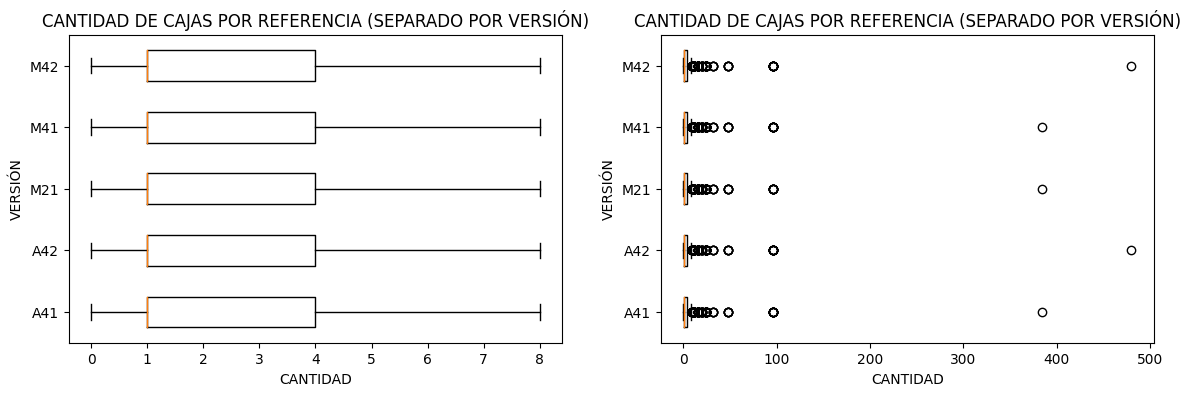

In [ ]:
fig, ax = plt.subplots(figsize=(14,4),nrows=1,ncols=2)
ax[0].boxplot(DSNX_2,vert=False,labels=DSNX_2.columns,showfliers=False) #Asi puedo sacar outliers
ax[0].set_xlabel('CANTIDAD')
ax[0].set_ylabel('VERSIÓN')
ax[0].set_title('CANTIDAD DE CAJAS POR REFERENCIA (SEPARADO POR VERSIÓN)')
ax[1].boxplot(DSNX_2,vert=False,labels=DSNX_2.columns,showfliers=True)
ax[1].set_xlabel('CANTIDAD')
ax[1].set_ylabel('VERSIÓN')
ax[1].set_title('CANTIDAD DE CAJAS POR REFERENCIA (SEPARADO POR VERSIÓN)')

In [ ]:
DSNX_3 = DSNX.drop_duplicates(subset=['VERSION', 'BASE']) #Quiero saber cuantas bases de cada tipo tengo por versión
DSNX_3

,CLASE,VERSION,CONTENEDOR,BASE,TIPO BASE,LARGO BASE,ANCHO BASE,ALTURA BASE,PESO BASE,CAJA,...,REFERENCIA,UNID/CAJA,CAJAS/BASE,REFS/BASE,INSPECCIÓN,REFS/CAJA,VOLUMEN CAJA,VOL TOTAL,CANT PALLETS,TIPO PALLET
0,F1,M42,CMAU4908460,AF0001,IRON FRAME,2110,600,1200,205.00,AF0001,...,2804110-BU01,16,1,1,0,1,0.02210,0.1326,1,DIRECTO
1,F1,M42,CMAU4908460,AF0002,IRON FRAME,2110,600,1200,205.00,AF0002,...,2804110-BU01,16,1,1,0,1,0.02210,0.1326,1,DIRECTO
2,F1,M42,CMAU4908460,AF0003,IRON FRAME,2110,600,1200,205.00,AF0003,...,2804110-BU01,16,1,1,0,1,0.02210,0.1326,1,DIRECTO
3,F1,M42,CMAU4908460,AF0004,IRON FRAME,2110,600,1200,205.00,AF0004,...,2804110-BU01,16,1,1,0,1,0.02210,0.1326,1,DIRECTO
4,F1,M42,CMAU4908460,AF0005,IRON FRAME,2110,600,1200,205.00,AF0005,...,2804110-BU01,16,1,1,0,1,0.02210,0.1326,1,DIRECTO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23503,A,A42,MRSU3285393,MF004,IRON FRAME,2250,1800,1000,406.57,MF004,...,6901000P201D,61,1,1,0,1,4.05000,7.4250,5,DIRECTO
23504,A,A42,MRSU3285393,MF005,IRON FRAME,2250,1800,1000,740.00,MF005,...,7301200-BU52,96,3,3,0,3,1.35000,1.3500,1,DIRECTO
23507,A,A42,MRSU3285393,MF006,IRON FRAME,2250,1800,1000,664.00,MF006,...,6801000P201D,61,1,1,0,1,4.05000,6.0750,4,DIRECTO
23508,A,A42,MRSU3285393,MF007,IRON FRAME,2250,1800,1000,616.44,MF007,...,7301300-BU50,48,2,2,0,2,2.02500,3.0375,2,DIRECTO


### Graficamos cuantas cajas vienen por base, diferenciando por versión y si la base es inspeccionable o no.
Como es de esperarse, en general las bases que no son inspeccionables traen pocas cajas, mientras que las inspeccionables en promedio traen una cantidad considerable de cajas. No varía mucho por versión.

Seaborn: GRÁFICO 1

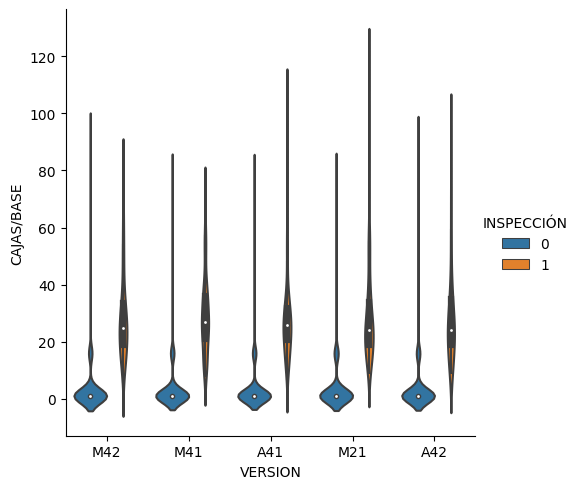

In [ ]:
sns.catplot(data=DSNX_3,kind='violin',y='CAJAS/BASE',x='VERSION',hue='INSPECCIÓN',split=False)

In [ ]:
DSNX_4 = DSNX.groupby(['REFERENCIA', 'VERSION'])['REFERENCIA'].nunique().unstack() #Con esto veo en que versión se usa cada referencia
DSNX_4 = DSNX_4.fillna(0)
DSNX_4 = DSNX_4[(DSNX_4 != 1).any(axis=1)]
DSNX_4['INDEX'] = DSNX_4.index

### Graficamos en que versión se utiliza cada referencia.
Cuando el punto está a la derecha, la referencia se usa en la versión correspondiente, si no se usa aparece a la izquierda.

Seaborn: GRÁFICO 2

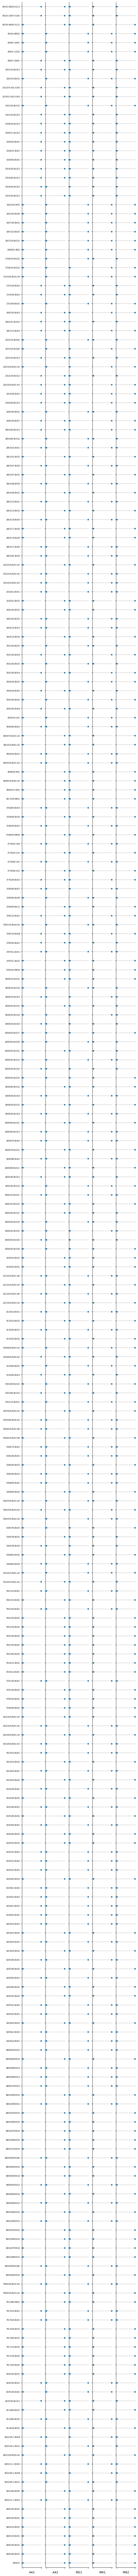

In [ ]:
g = sns.PairGrid(DSNX_4.sort_values("INDEX", ascending=True), x_vars=DSNX_4.columns[:5], y_vars=['INDEX'], height=120, aspect=0.01)
g.map(sns.stripplot)
g.set(ylabel="")
g.axes[0, 0].tick_params(axis='y', labelsize=6)
for ax in g.axes.flat:
    ax.set_xticklabels([])
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

In [ ]:
DSNX_5 = DSNX.drop_duplicates(subset=['VERSION', 'CLASE', 'REFERENCIA']) #Como cada referencia ya tiene el total de pallets que involucra, borro duplicados
DSNX_5 = DSNX_5.pivot_table(index=['VERSION','CLASE'], columns='TIPO PALLET', values='CANT PALLETS', aggfunc='sum') #Calculo la suma de pallets por clase
DSNX_5 = DSNX_5.fillna(0)
DSNX_5 = DSNX_5.groupby('CLASE').mean() #Promedio las versiones
DSNX_5

TIPO PALLET,DEDICADO,DIRECTO,MIXTO
CLASE,,,
A,0.0,70.8,9.000000
CA1,4.0,0.0,29.800000
CA2,4.0,1.0,34.600000
CA3,4.0,0.0,37.200000
CA4,3.0,7.0,36.000000
CA5,7.0,0.0,17.000000
CA6,31.0,0.0,24.800000
CA7,11.0,0.0,23.800000
CH1,12.0,201.8,10.000000


### Graficamos cuantos pallets de cada tipo pertenecen a cada clase, promediando por versión.
Los resultados son bastante lógicos, ya que las clases S y CH1 conllevan gran cantidad de pallets directos. Esto sucede porque suelen estar compuestos por referencias que conllevan gran volumen, son piezas estructurales del producto.
A su vez, la clase TO suele estar compuesta por pallets mixtos, ya que es la que tiene más referencias distintas.

Seaborn: GRÁFICO 3

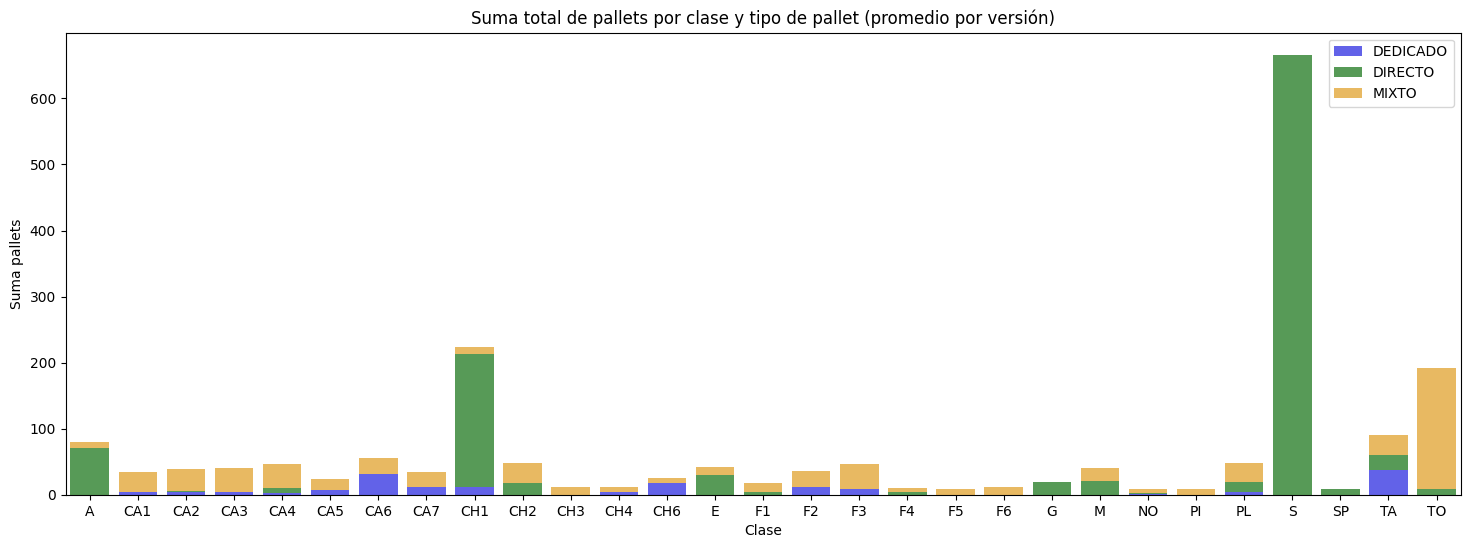

In [ ]:
plt.figure(figsize=(18, 6))
sns.barplot(data=DSNX_5, x=DSNX_5.index, y='DEDICADO', color='blue', label='DEDICADO', alpha=0.7)
sns.barplot(data=DSNX_5, x=DSNX_5.index, y='DIRECTO', color='green', label='DIRECTO', alpha=0.7, bottom=DSNX_5['DEDICADO'])
sns.barplot(data=DSNX_5, x=DSNX_5.index, y='MIXTO', color='orange', label='MIXTO', alpha=0.7, bottom=DSNX_5['DEDICADO'] + DSNX_5['DIRECTO'])

plt.title('Suma total de pallets por clase y tipo de pallet (promedio por versión)')
plt.xlabel('Clase')
plt.ylabel('Suma pallets')
plt.legend()

In [ ]:
#El objetivo aqui fue generar una matriz con la versión como índice y como columna, para poder ver la diferencia de piezas de versión a versión
DSNX_6 = pd.DataFrame(index=DSNX_4.columns[:5], columns=DSNX_4.columns[:5])
total=0
for k in DSNX_4.columns[:5]:
  for j in DSNX_4.columns[:5]:
    for i in DSNX_4.index:
      if DSNX_4.loc[i,j]!=DSNX_4.loc[i,k]:
        total+=1 #Voy recorriendo el DSNX_4 para cada par de versiones, si las dos valen 1 o 0, significa que ambas usan (o no) la referencia. Por ello solo sumo uno si los valores difieren
    DSNX_6.loc[k,j]=total
    total=0
df = DSNX_6.astype(float)
DSNX_6 = df.to_numpy()
df

VERSION,A41,A42,M21,M41,M42
VERSION,,,,,
A41,0.0,195.0,90.0,64.0,250.0
A42,195.0,0.0,267.0,249.0,63.0
M21,90.0,267.0,0.0,36.0,218.0
M41,64.0,249.0,36.0,0.0,194.0
M42,250.0,63.0,218.0,194.0,0.0


### Graficamos un mapa de calor para ver la diferencia entre versiones.
Obviamente la diagonal valdrá 0 ya que sería una comparación entre la misma versión, luego vemos que la que tiene más diferencias es la M21 con la A42.

Esto tiene sentido ya que cada versión consta de 3 funciones, el producto puede ser A o M, 2 o 4 y 1 o 2. Las versiones A41 y A42 difieren solo en una función, mientras que las M21 y A42 difieren en las tres funciones (por ello son las que más difieren en las piezas que usan).

Matplotlib: GRÁFICO 3

Text(0.5, 1.0, 'DIFERENCIA DE USO DE REFERENCIAS ENTRE VERSIONES')

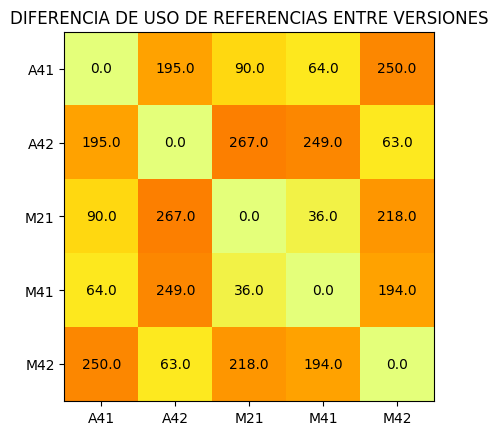

In [ ]:
plt.imshow(DSNX_6, cmap='Wistia')

for i in range(DSNX_6.shape[0]):
    for j in range(DSNX_6.shape[1]):
        plt.text(j, i, str(DSNX_6[i, j]), ha='center', va='center', color='k',fontsize=10)

plt.xticks(range(DSNX_6.shape[1]), df.columns)
plt.yticks(range(DSNX_6.shape[0]), df.index)
plt.title('DIFERENCIA DE USO DE REFERENCIAS ENTRE VERSIONES')